<a href="https://colab.research.google.com/github/KrishPraba/Pump-it-Up-Data-Mining-the-Water-Table/blob/main/Pump_it_Up_Modelling_%26_Post_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Installing Necessary Libraries**

In [1]:
!pip install catboost
!pip install ipywidgets
!pip install shap
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 67.4 MB 32 kB/s 
     |████████████████████████████████| 356 kB 5.3 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491653 sha256=08fde0a50536a1d4bf3a8c736ad5a48cabe978a811b32181a9d547fe5468d5b0
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support, confusion_matrix
import re
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#**Loading Data**

In [3]:
import pandas as pd

train_test_unencoded = pd.read_csv( "/content/drive/MyDrive/Machine Learning/preprocessed_unencoded_data.csv" )   # Unencoded features dataset used for CATboost

train_test_encoded = pd.read_csv( "/content/drive/MyDrive/Machine Learning/preprocessed_encoded_data.csv" )       # Encoded features dataset used for other classifiers

labels_df = pd.read_csv( "/content/drive/MyDrive/Machine Learning/Train_set_labels.csv" )                         # Labels set for the training set

In [7]:
# Seperating train and test set of both encoded and unencoded dataset

test_df_unencoded = train_test_unencoded.loc[train_test_unencoded['from'] == 'test']
test_df_unencoded.drop(columns=['from','Unnamed: 0'],inplace=True)

train_values_df_unencoded = train_test_unencoded.loc[train_test_unencoded['from'] == 'train']
train_values_df_unencoded.drop(columns=['from','Unnamed: 0'],inplace=True)

test_df_encoded = train_test_encoded.loc[train_test_encoded['from'] == 'test']
test_df_encoded.drop(columns=['from','Unnamed: 0'],inplace=True)

train_values_df_encoded = train_test_encoded.loc[train_test_encoded['from'] == 'train']
train_values_df_encoded.drop(columns=['from','Unnamed: 0'],inplace=True)

In [8]:
print(train_values_df_encoded.shape)
print(test_df_encoded.shape)
print(labels_df.shape)
print(train_values_df_unencoded.shape)
print(test_df_unencoded.shape)

(59400, 28)
(14850, 28)
(59400, 2)
(59400, 28)
(14850, 28)


In [9]:
labels_df = labels_df.drop(columns=['id'])

In [10]:
X_unencoded =train_values_df_unencoded
Y =labels_df
X_encoded =train_values_df_encoded


#**Building CAT Boost Model**

In [18]:
categorical_features_indices = np.where(X_unencoded.dtypes != np.float)[0]

In [19]:
categorical_features_indices

array([ 0,  2,  3,  4,  5,  8,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 27])

In [20]:
X_train, X_validation, y_train, y_validation = train_test_split(X_unencoded, Y, train_size=0.75, random_state=42)

In [21]:
model = CatBoostClassifier(
    loss_function = 'MultiClass'
)

In [22]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    verbose = False
);

In [23]:
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))

Simple model validation accuracy: 0.8116


In [45]:
model.fit(
    X_unencoded, Y,
    cat_features=categorical_features_indices,
    verbose = False
);

# **Other Modelling Approaches**

In [11]:
#Function to compute accuracy, f1 score, precision, recall and confusion matrix

def compute_metrics(pred,ground_labels):
    labels_all = ground_labels
    preds_all = list(pred)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels_all, preds_all)
    acc = accuracy_score(labels_all, preds_all)
    confusion_mat = confusion_matrix(labels_all, preds_all)
    # tn, fp, fn, tp = confusiton_mat.ravel()
    out_dict = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusiton_mat': confusion_mat
    }
    return out_dict

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_encoded, Y, test_size=0.3, random_state=142,stratify=Y)

**Random Forest Classifier**

---



In [49]:
clf=RandomForestClassifier(n_estimators=100,max_features='auto',random_state=0,max_depth=14)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(),scoring='accuracy')
rfecv.fit(X_train, y_train)

predicted_y = rfecv.predict(X_val)
result = compute_metrics(predicted_y,y_val)

print(result['accuracy'])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7919191919191919


**Ada Boost Classifier**

---



In [51]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=14), n_estimators=100,algorithm="SAMME.R", learning_rate=0.0001)
ada_clf.fit(X_train,y_train)

predicted_y = ada_clf.predict(X_val)
result = compute_metrics(predicted_y,y_val)

print(result['accuracy'])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7603815937149271


**XGB Classifier**

---



In [13]:
xgb = XGBClassifier(objective = 'multi:softmax',num_class = 3,max_depth = 14)
xgb.fit(X_train, y_train)

predicted_y = xgb.predict(X_val)
result = compute_metrics(predicted_y,y_val)

print(result['accuracy'])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.8051066217732884


**Other Classifiers used**

---



In [52]:
classifiers=[['Decision Tree Classification :',DecisionTreeClassifier()],
       ['Gradient Boosting Classification :', GradientBoostingClassifier()],
       ['Extra Tree Classification :', ExtraTreesClassifier()],
       ['Support Vector Classification :',SVC()]]
cla_pred=[]

In [53]:
for name,model1 in classifiers:
    print("-----------"+name+"-------------")
    model1.fit(X_train,y_train.values.ravel())
    predicted_y = model1.predict(X_val)
    score=compute_metrics(predicted_y,y_val)
    cla_pred.append(score)
    print()

-----------Decision Tree Classification :-------------

-----------Gradient Boosting Classification :-------------

-----------Extra Tree Classification :-------------

-----------Support Vector Classification :-------------



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [54]:
for i in range(len(classifiers)):
  # print("-----------"+classifiers[i][0]+"-------------")
  result = cla_pred[i]
  print('\033[1m' + classifiers[i][0] + '\033[0m')
  print(result['accuracy'])
  print()

Decision Tree Classification :
0.7267115600448933

Gradient Boosting Classification :
0.7508417508417509

Extra Tree Classification :
0.8037598204264871

Support Vector Classification :
0.5430976430976431



#**Post-processing**

**Feature Importance**

---



**Random Forest**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 23


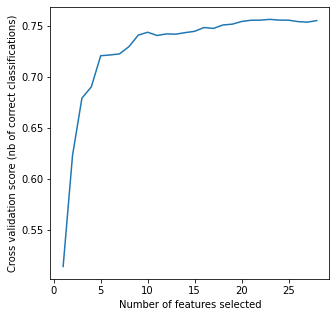

In [37]:
#Using the random forest classifier from above

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [43]:
print('\033[1m' + "Feature grid scores" + '\033[0m')
print(rfecv.grid_scores_)
print()

print('\033[1m' + "Feature support" + '\033[0m')
print(rfecv.support_)
print()


print('\033[1m' + "Feature rank" + '\033[0m')
print(rfecv.ranking_)
print()

Feature grid scores
[0.51397306 0.62277778 0.67885522 0.68994949 0.72048822 0.72121212
 0.72227273 0.7293266  0.7406734  0.74346801 0.74030303 0.74185185
 0.74161616 0.74311448 0.74439394 0.74809764 0.74722222 0.75057239
 0.75139731 0.7539899  0.75525253 0.7553367  0.75611111 0.75538721
 0.75530303 0.75390572 0.753367   0.75489899]

Feature support
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True False  True False  True  True False  True
 False  True  True  True]

Feature rank
[1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 6 1 5 1 1 2 1 4 1 1 1]



In [40]:
rfecv_features = list(X_encoded.columns.values[rfecv.support_])
print(rfecv_features)

['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'scheme_name', 'construction_year', 'extraction_type', 'payment_type', 'quantity_group', 'source', 'waterpoint_type']


**SHAP**

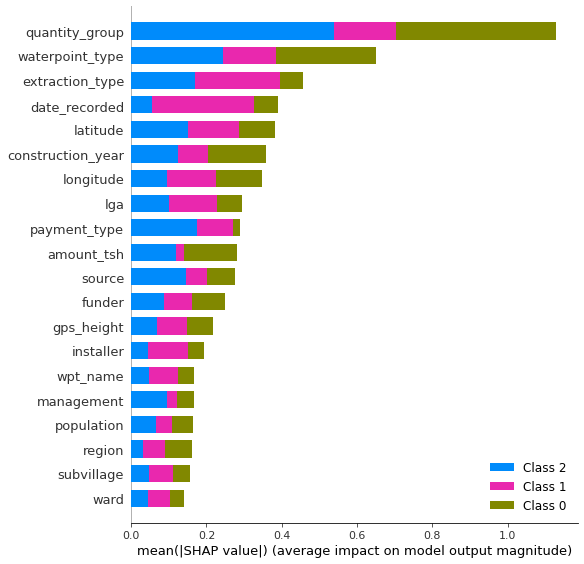

In [14]:
output = shap.TreeExplainer(xgb)
shap_values = output.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

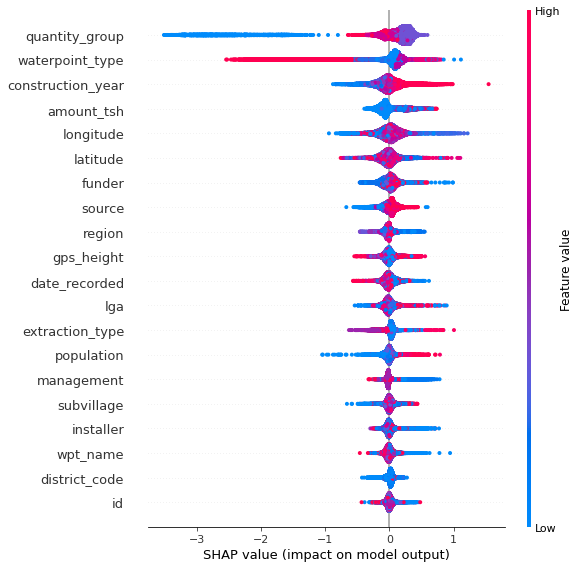

In [15]:
shap.summary_plot(shap_values[0], X_val)      #Functional

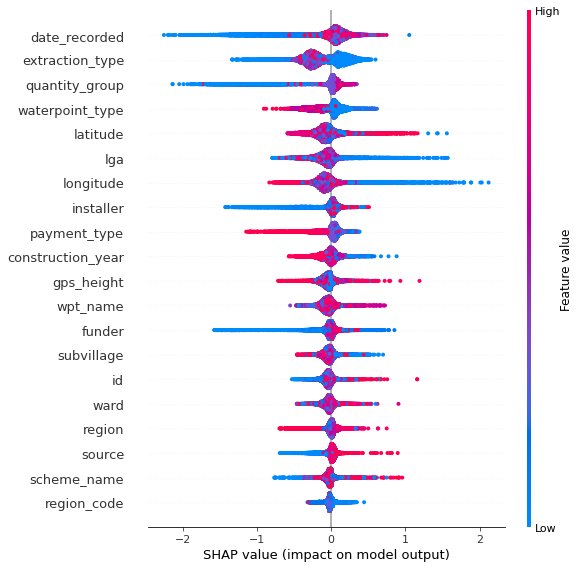

In [16]:
shap.summary_plot(shap_values[1], X_val)      #Functional but needs repair

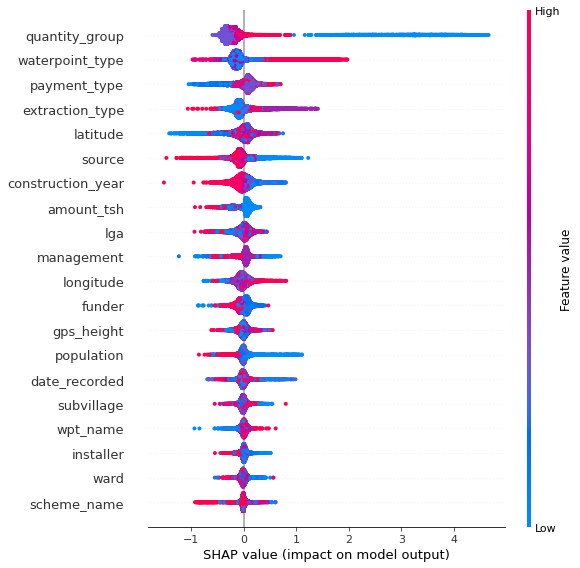

In [17]:
shap.summary_plot(shap_values[2], X_val)      #Non Functional

#**Submission**

In [ ]:
y_pred = model1.predict(test_df_encoded)     #if other classifiers are used

In [31]:
y_pred = model.predict(test_df_unencoded)   #if CAT BOOST is used

In [32]:
prediction = pd.DataFrame(
    y_pred
)

In [33]:
submission_df = pd.read_csv("/content/drive/MyDrive/Machine Learning/SubmissionFormat.csv")
print(submission_df.shape)

(14850, 2)


In [34]:
submission_df['status_group'] = prediction[0]
submission_df.info

<bound method DataFrame.info of           id    status_group
0      50785      functional
1      51630      functional
2      17168      functional
3      45559  non functional
4      49871      functional
...      ...             ...
14845  39307  non functional
14846  18990      functional
14847  28749      functional
14848  33492      functional
14849  68707  non functional

[14850 rows x 2 columns]>


In [36]:
submission_df.to_csv('/content/drive/MyDrive/Machine Learning/my_submission15.csv')